In [1]:
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'

import random, statistics
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torchinfo

from monai.losses.dice import DiceLoss, DiceFocalLoss, GeneralizedDiceFocalLoss
from monai.metrics import MeanIoU, SurfaceDiceMetric, DiceHelper # type:ignore
from schedulefree import AdamWScheduleFree
from came_pytorch import CAME
from madgrad import MADGRAD

from stuff.found.focal_tversky_loss import focal_tversky

from glio.train2 import *
from glio.train2.cbs_summary import Summary
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.plot.figure import Figure, qimshow, qimshow_batch, qlinechart, qpath10d, qpath2d
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator, get_all_files, get0, get1
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq, block
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01
from glio.datasets.BRaTS2024_preloaded import get_ds_2d, get_ds_around, loader_2d, loader_around, loader_around_fix

from glio.specific.brats import plot_preds


d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
TITLE = "BRATS2024 2D general overnight2"
bratstrain = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\train hist.joblib")
bratstest = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\test hist.joblib")

dstrain = DSToTarget()
dstest = DSToTarget()
dstrain.add_samples(bratstrain, loader_around_fix, None, get0, get1)
dstest.add_samples(bratstest, loader_around_fix, None, get0, get1)



In [3]:
show_slices(dstrain[0][0])

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=5, description='s0', max=11)…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [4]:
from monai.networks.nets import VNet # type:ignore
print(f"{count_parameters(VNet(2, 16, 4)) = }")
summary(VNet(2, 16, 4), (8, 16, 96,96))

count_parameters(VNet(2, 16, 4)) = 9366348
path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.vnet.VNet/in_tr/conv_block/convtorch.nn.modules.conv.Conv2d                 (8, 16, 96, 96)          (8, 16, 96, 96)          6400      0         
monai.networks.nets.vnet.VNet/in_tr/conv_block/adn/Ntorch.nn.modules.batchnorm.BatchNorm2d       (8, 16, 96, 96)          (8, 16, 96, 96)          32        33        
monai.networks.nets.vnet.VNet/in_tr/act_functiontorch.nn.modules.activation.ELU              (8, 16, 96, 96)          (8, 16, 96, 96)          0         0         
monai.networks.nets.vnet.VNet/down_tr32/down_convtorch.nn.modules.conv.Conv2d                 (8, 16, 96, 96)          (8, 32, 48, 48)          2048      0         
monai.networks.nets.vnet.VNet/down_tr32/bn1  torch.nn.modules.batchnorm.BatchNorm2d       (8, 32, 48, 48)          (8, 32, 48, 48)  

In [5]:
class ConcatZeroChannels:
    def __init__(self, dataloader, resulting_channels):
        self.dataloader = dataloader
        self.resulting_channels=resulting_channels
    def __len__(self): return len(self.dataloader)
    def __iter__(self): 
        for inputs, targets in self.dataloader:
            shape = list(inputs.shape)
            shape[1] = self.resulting_channels - shape[1]
            inputs = torch.cat((inputs, torch.zeros(shape)), dim=1)
            yield inputs, targets


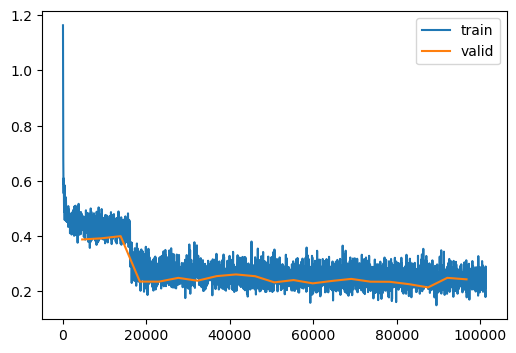

Keyboard interrupt, stopping the training...
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0002; max: 0.0603; last: 0.0006
grad std: min: 0.1077; max: 3.7992; last: 0.3279
grad-update mean: min: 0.0502; max: 1.5859; last: 0.1505
grad-update angle: min: 1.4320; max: 1.7562; last: 1.6143
param mean: min: -0.0253; max: 0.0003; last: -0.0253
param var: min: 0.0004; max: 0.3093; last: 0.3093
param min: min: -13.6463; max: -0.4270; last: -13.6463
param max: min: 1.0100; max: 11.6187; last: 11.6187
time: min: 0.5695; max: 40075.1010; last: 40075.1010
lr: min: 0.0100; max: 0.0100; last: 0.0100
train loss: min: 0.1427; max: 1.1637; last: 0.2894
train accuracy: min: 0.0554; max: 0.9824; last: 0.9566
train iou: min: 0.0323; max: 0.9651; last: 0.9310
train precision: min: 0.0554; max: 0.9824; last: 0.9566
train recall: min: 0.0554; max: 0.9824; last: 0.9566
train f1: min: 0.0554; max: 0.9824; last: 0.9566
train average precision: min: 0.2588; max: 0.5165; last: 0.4646
tra

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


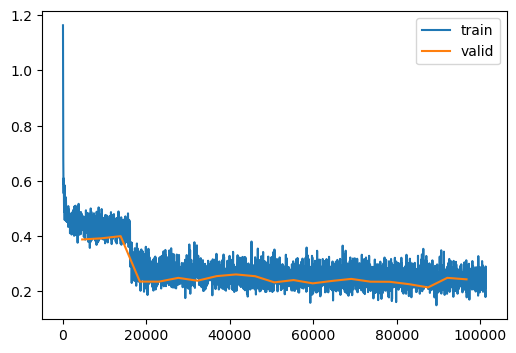

RuntimeError: Given groups=1, weight of size [16, 16, 5, 5], expected input[1, 12, 96, 96] to have 16 channels, but got 12 channels instead

In [11]:
from glio.train2.cbs_default_overrides import CallTrainAndEvalOnOptimizer
MODEL = VNet(2, 16, 4)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 64
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = ConcatZeroChannels(DataLoader(dstrain, BATCH_SIZE, shuffle=True), 16)
dltest = ConcatZeroChannels(DataLoader(dstest, BATCH_SIZE), 16)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), Log_LastGradsAngle(128), Log_GradPath(1)
              Log_UpdateDist(128), Log_GradDist(128), Log_GradUpdateAngle(128), Log_ParamDist(128),
              Log_LastUpdatesAngle(128),
              Log_ParamPath(32), Log_UpdatePath(32),
              Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_Precision(4, True, True, step=16),
              Torcheval_Recall(4, True, True, step=16),
              Torcheval_Dice(4, True, True, step=8, name='f1'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              FastProgressBar(step_batch=128, plot=True),
              Summary(),
              PlotSummary(),
              CallTrainAndEvalOnOptimizer(),
              )

LEARNER_NAME = f"brats-hist-around1 32 {NAME} AdamW3e-3 onecycle eps3e-6 GDiceFocalLoss 2"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False)
plt.show()
plot_preds(learner, dstrain[200])
plot_preds(learner, dstest[500])
plot_preds(learner, dstrain[1650])
plot_preds(learner, dstest[1650])

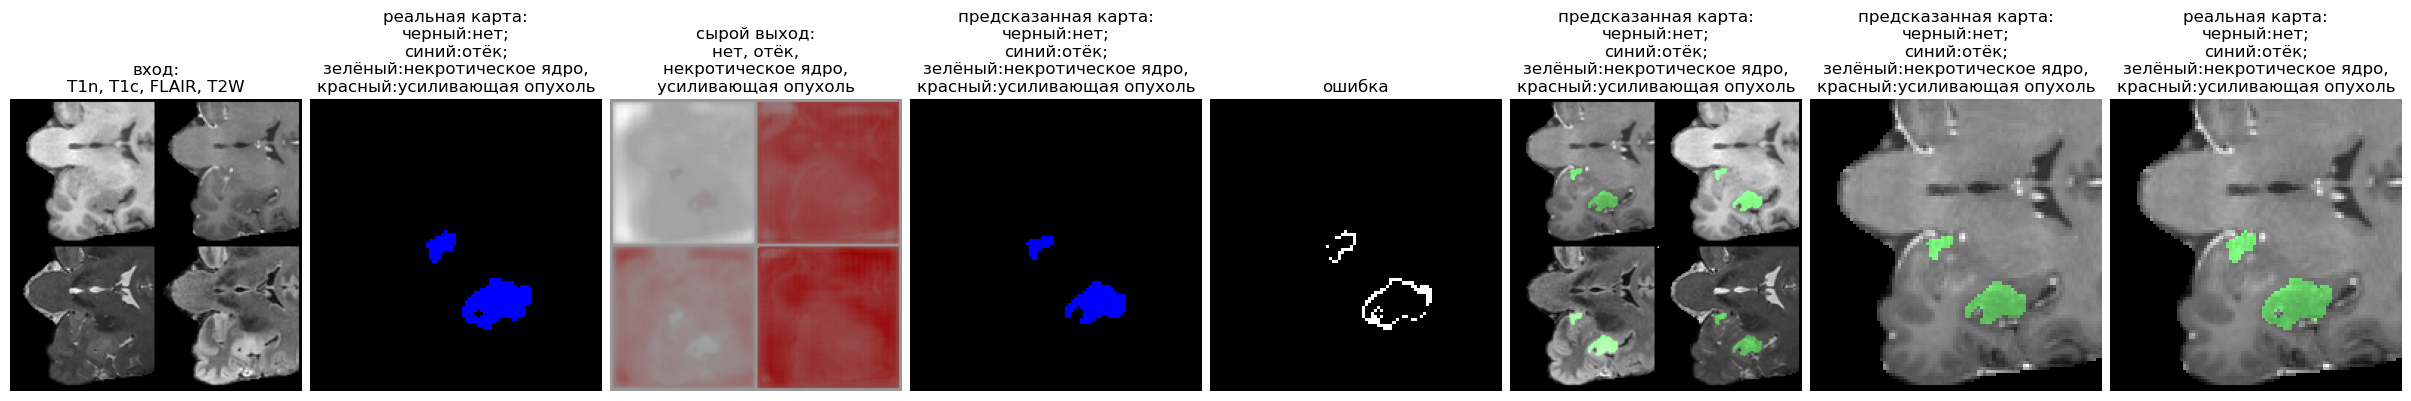

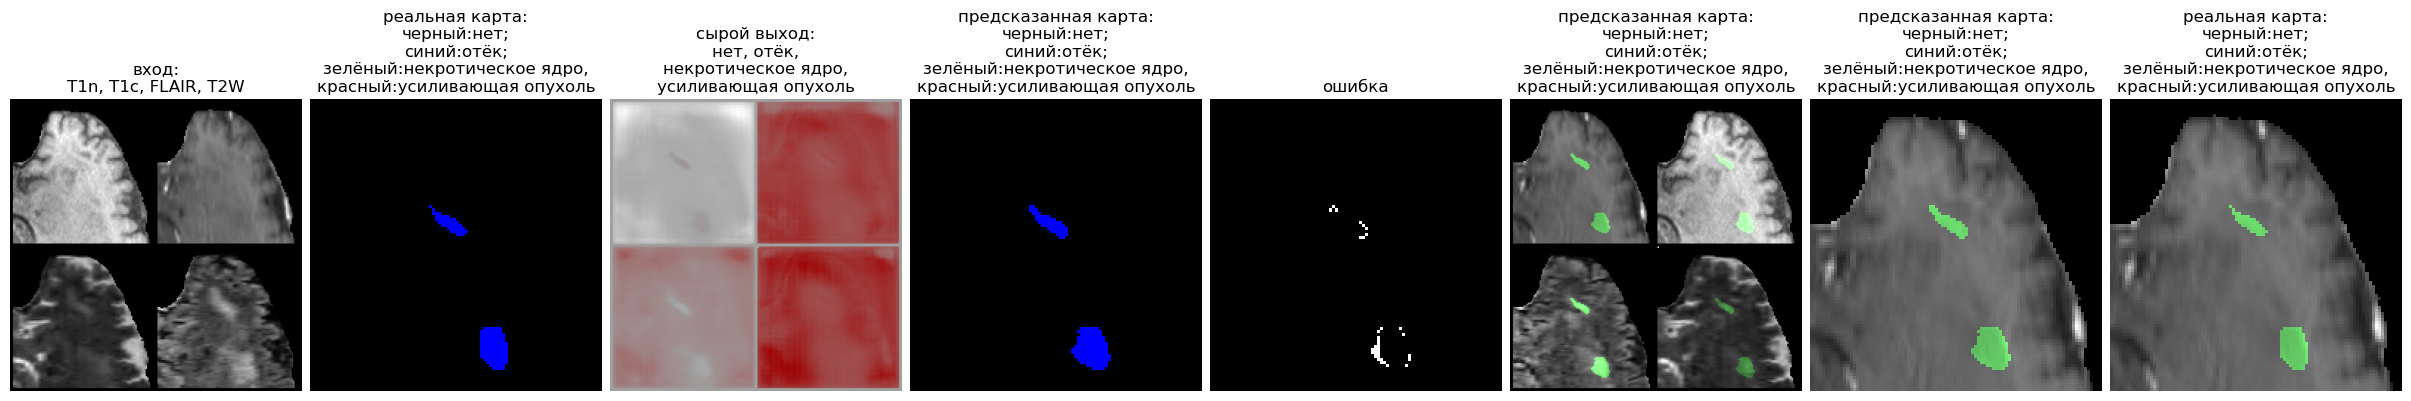

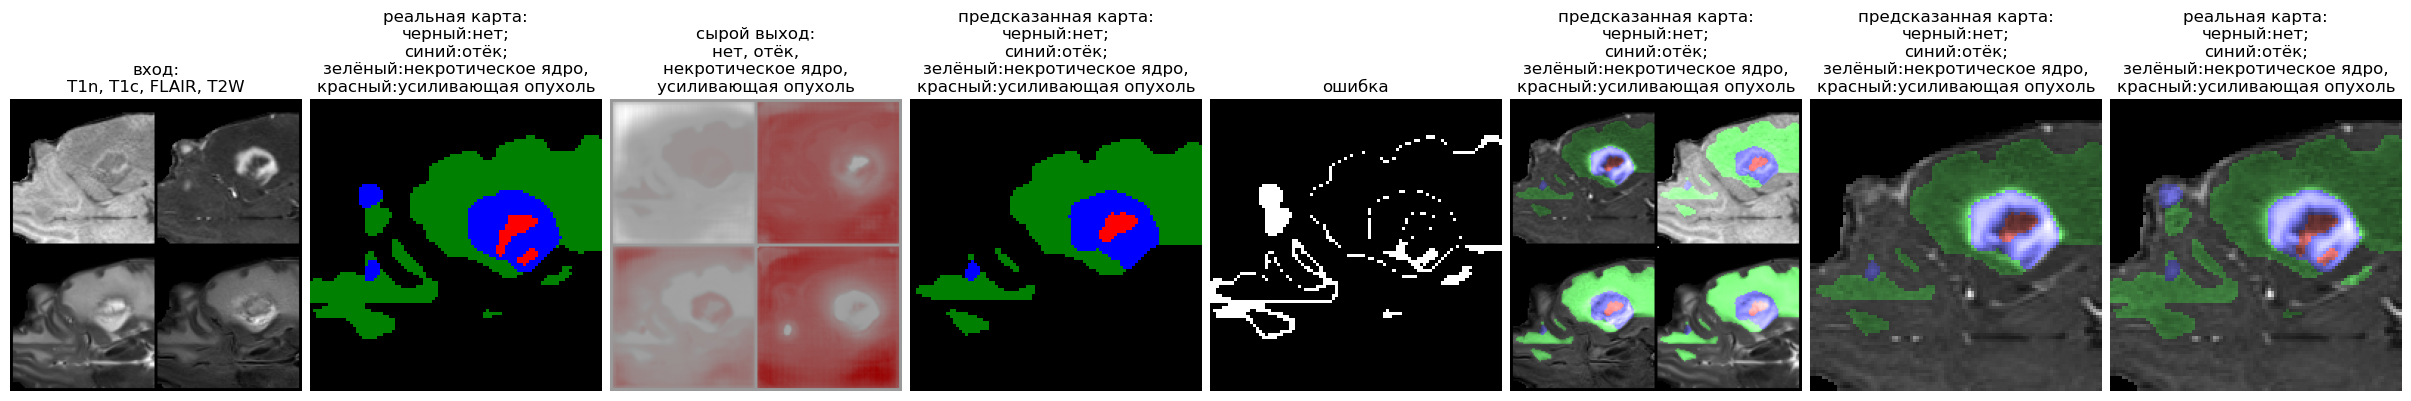

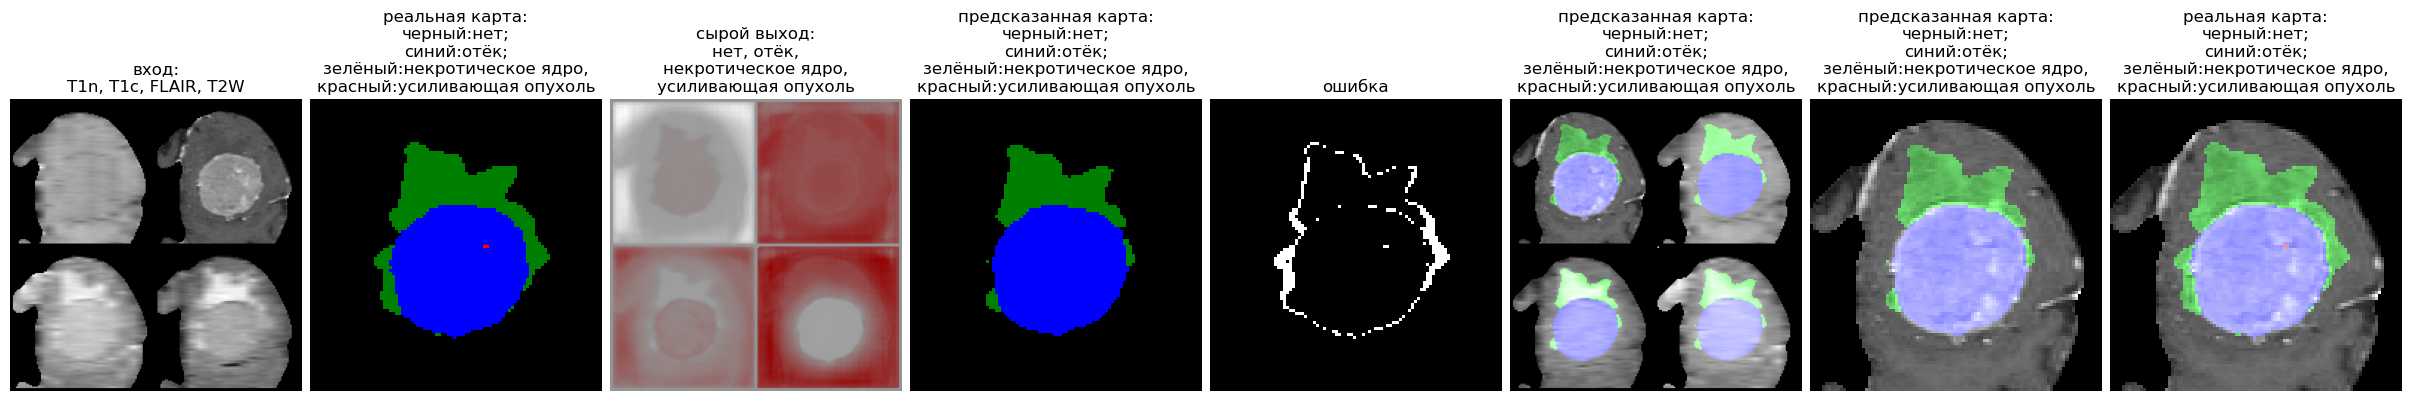

In [13]:
plot_preds(learner, dstrain[200], expand_channels=16)
plot_preds(learner, dstest[500], expand_channels=16)
plot_preds(learner, dstrain[1650], expand_channels=16)
plot_preds(learner, dstest[1650], expand_channels=16)